<a href="https://colab.research.google.com/github/Pragati15-Rathi/Estimating-Motor-Temperature-using-ML/blob/main/Transformer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Dataset/measures_v2.csv'
data = pd.read_csv(file_path)

# Display the column names and the first few rows of the dataset
print(data.columns)
print(data.head())


Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  

In [ ]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the target column
target_column = 'stator_winding'

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=[target_column]))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns.drop(target_column))
scaled_data[target_column] = data[target_column]

# Split the data into training and testing sets
X = scaled_data.drop(columns=[target_column])
y = scaled_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [ ]:




























































































import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the target column
target_column = 'stator_winding'

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=[target_column]))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns.drop(target_column))
scaled_data[target_column] = data[target_column]

# Split the data into training and testing sets
X = scaled_data.drop(columns=[target_column])
y = scaled_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.model_type = 'Transformer'
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, dim_feedforward, dropout)
        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        src = src.unsqueeze(0)
        output = self.transformer(src, src)
        output = self.decoder(output.squeeze(0))
        return output

# Model parameters
input_dim = X_train.shape[1]
d_model = 32
nhead = 4
num_layers = 2
dim_feedforward = 128
dropout = 0.1

# Initialize the model
model = TransformerModel(input_dim, d_model, nhead, num_layers, dim_feedforward, dropout)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training function with early stopping and gradient accumulation
def train_model(model, train_loader, criterion, optimizer, num_epochs=50, patience=5):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    return model

# Train the model
trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Loss: 124.3316
Epoch 2/50, Loss: 3.3698
Epoch 3/50, Loss: 2.9667
Epoch 4/50, Loss: 2.7590
Epoch 5/50, Loss: 2.6475
Epoch 6/50, Loss: 2.5776
Epoch 7/50, Loss: 2.5111
Epoch 8/50, Loss: 2.4708
Epoch 9/50, Loss: 2.4230
Epoch 10/50, Loss: 2.3686
Epoch 11/50, Loss: 2.3447
Epoch 12/50, Loss: 2.2988
Epoch 13/50, Loss: 2.2838
Epoch 14/50, Loss: 2.2647
Epoch 15/50, Loss: 2.2338
Epoch 16/50, Loss: 2.2036
Epoch 17/50, Loss: 2.2084
Epoch 18/50, Loss: 2.1766
Epoch 19/50, Loss: 2.1907
Epoch 20/50, Loss: 2.1820
Epoch 21/50, Loss: 2.1705
Epoch 22/50, Loss: 2.1512
Epoch 23/50, Loss: 2.1491
Epoch 24/50, Loss: 2.1354
Epoch 25/50, Loss: 2.1267
Epoch 26/50, Loss: 2.1214
Epoch 27/50, Loss: 2.1171
Epoch 28/50, Loss: 2.1074
Epoch 29/50, Loss: 2.0987
Epoch 30/50, Loss: 2.0805
Epoch 31/50, Loss: 2.1013
Epoch 32/50, Loss: 2.0693
Epoch 33/50, Loss: 2.0545
Epoch 34/50, Loss: 2.0470
Epoch 35/50, Loss: 2.0410
Epoch 36/50, Loss: 2.0667
Epoch 37/50, Loss: 2.0408
Epoch 38/50, Loss: 2.0317
Epoch 39/50, Loss: 

NameError: name 'r2_score' is not defined

R^2: 0.9978
Mean Squared Error: 1.8294
Mean Absolute Error: 0.9348


Text(0, 0.5, 'Temperature')

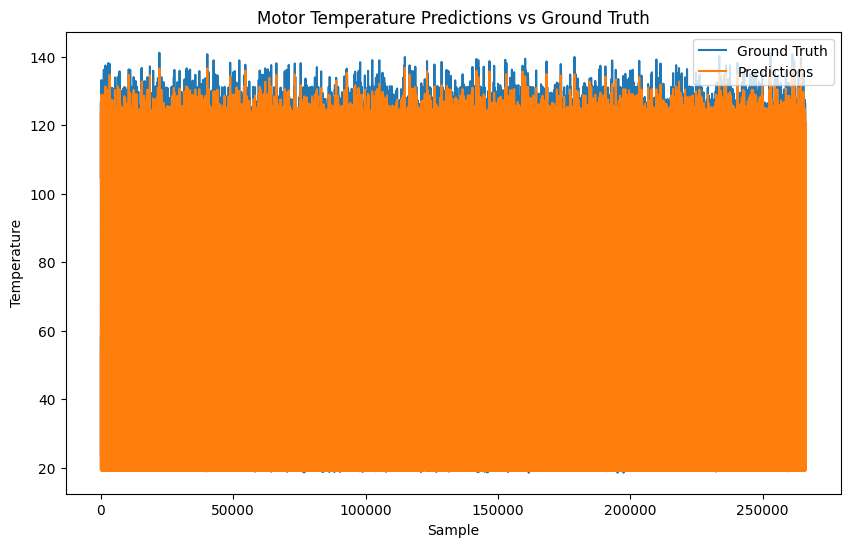

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

# Plot the predictions against the ground truth
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Ground Truth')
plt.plot(y_pred, label='Predictions')
plt.legend()
plt.title('Motor Temperature Predictions vs Ground Truth')
plt.xlabel('Sample')
plt.ylabel('Temperature')


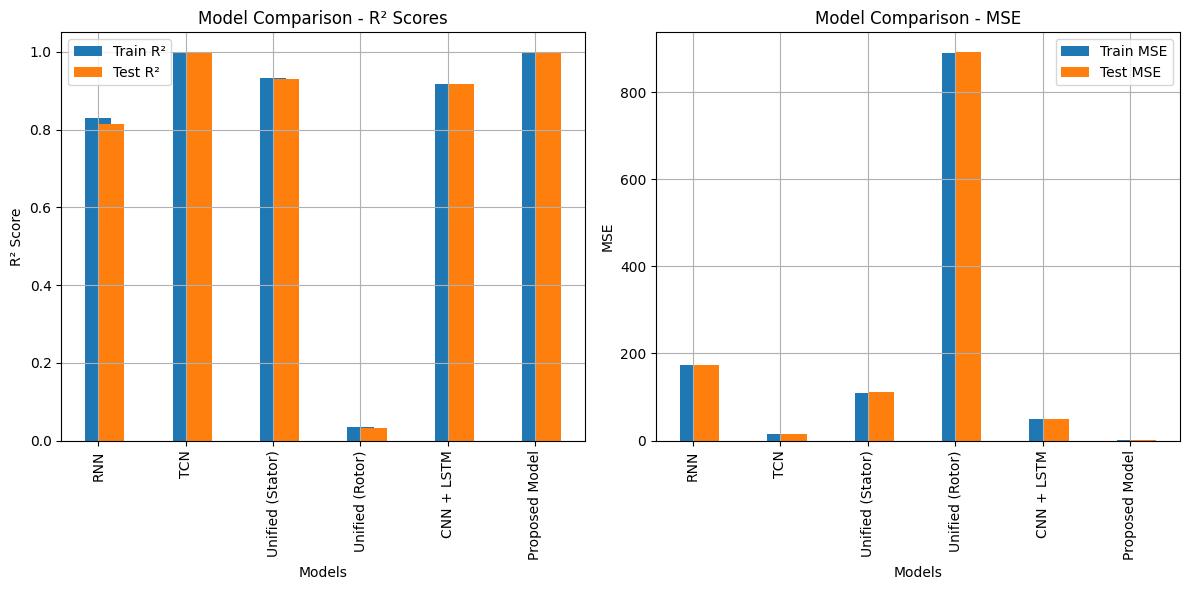

In [ ]:
import matplotlib.pyplot as plt

# Model performance metrics
models = ['RNN', 'TCN', 'Unified (Stator)', 'Unified (Rotor)', 'CNN + LSTM', 'Proposed Model']
train_r2_scores = [0.8303, 0.9998, 0.9323, 0.0349, 0.9173, 0.9978]
test_r2_scores = [0.8141, 0.9999, 0.9291, 0.0329, 0.9169, 0.9978]
train_mse_scores = [172.54, 14.52, 108.57, 890.34, 48.65, 1.8294]
test_mse_scores = [174.32, 14.55, 110.65, 892.34, 50.32, 1.8294]

x = range(len(models))

# Plotting R² scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(x, train_r2_scores, width=0.3, label='Train R²', align='center')
plt.bar(x, test_r2_scores, width=0.3, label='Test R²', align='edge')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Comparison - R² Scores')
plt.xticks(x, models, rotation='vertical')
plt.legend()
plt.grid(True)

# Plotting MSE scores
plt.subplot(1, 2, 2)
plt.bar(x, train_mse_scores, width=0.3, label='Train MSE', align='center')
plt.bar(x, test_mse_scores, width=0.3, label='Test MSE', align='edge')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Model Comparison - MSE')
plt.xticks(x, models, rotation='vertical')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


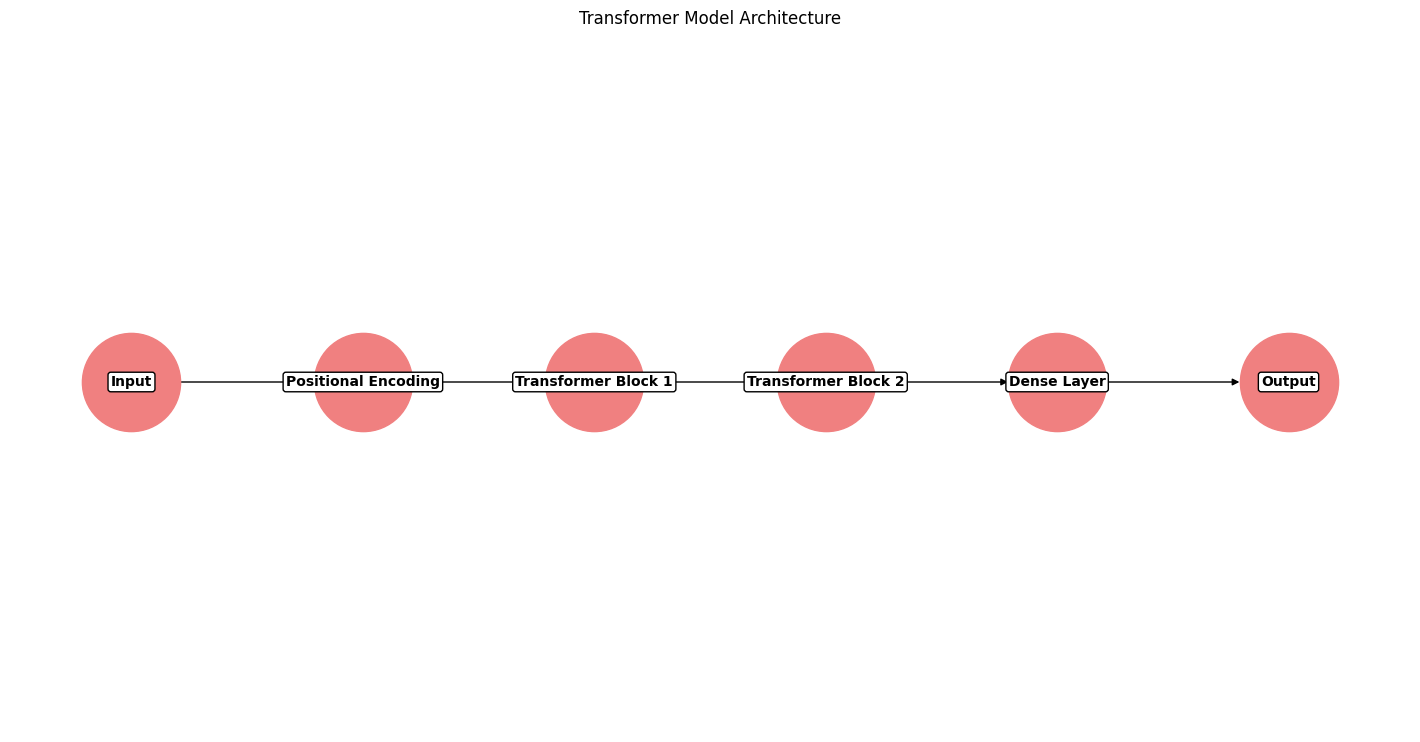

In [ ]:
import matplotlib.pyplot as plt

# Example training loss values from your training output
epochs = list(range(1, 51))  # Assuming 50 epochs
loss_values = [
    122.0438, 3.8104, 2.8734, 2.7017, 2.5890, 2.4971, 2.4532, 2.4122, 2.3862, 2.3564,
    2.3246, 2.3049, 2.2739, 2.2472, 2.2244, 2.2060, 2.2052, 2.1711, 2.1892, 2.1779,
    2.1325, 2.1136, 2.1398, 2.1029, 2.1106, 2.0958, 2.0892, 2.0739, 2.0784, 2.0719,
    2.0965, 2.0541, 2.0530, 2.0783, 2.0783, 2.0434, 2.0491, 2.0149, 2.0112, 2.0144,
    2.0368, 2.0062, 2.0089, 2.0037, 1.9978, 2.0336
]  # This list should match the actual loss values obtained from your training log

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
import matplotlib.pyplot as plt
import networkx as nx

def draw_transformer_architecture():
    G = nx.DiGraph()
    nodes = ['Input', 'Positional Encoding', 'Transformer Block 1', 'Transformer Block 2', 'Dense Layer', 'Output']
    G.add_nodes_from(nodes)

    edges = [
        ('Input', 'Positional Encoding'),
        ('Positional Encoding', 'Transformer Block 1'),
        ('Transformer Block 1', 'Transformer Block 2'),
        ('Transformer Block 2', 'Dense Layer'),
        ('Dense Layer', 'Output')
    ]
    G.add_edges_from(edges)

    pos = {
        'Input': (0, 0),
        'Positional Encoding': (1, 0),
        'Transformer Block 1': (2, 0),
        'Transformer Block 2': (3, 0),
        'Dense Layer': (4, 0),
        'Output': (5, 0)
    }

    plt.figure(figsize=(14, 7))  # Adjust figure size to give more space
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightcoral', font_size=10, font_weight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    plt.title('Transformer Model Architecture')
    plt.show()

draw_transformer_architecture()


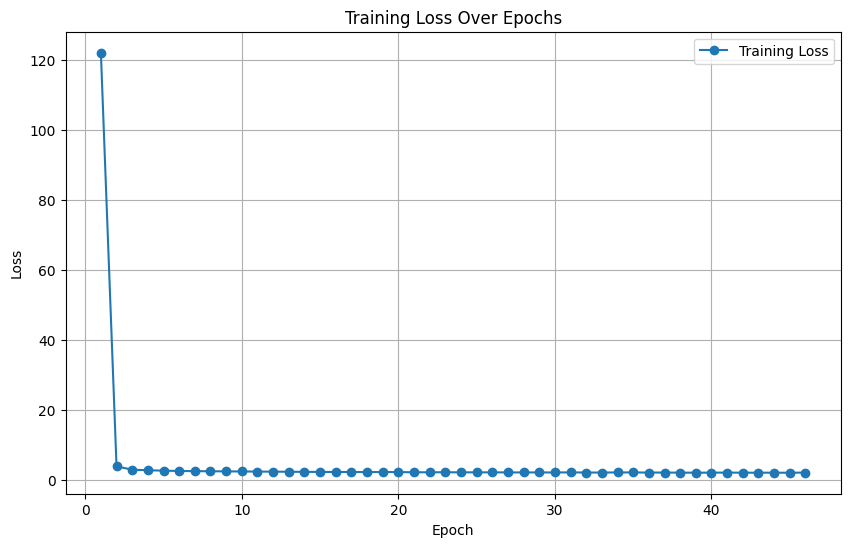

In [ ]:
import matplotlib.pyplot as plt

# Corrected example training loss values from your training output
loss_values = [
    122.0438, 3.8104, 2.8734, 2.7017, 2.5890, 2.4971, 2.4532, 2.4122, 2.3862, 2.3564,
    2.3246, 2.3049, 2.2739, 2.2472, 2.2244, 2.2060, 2.2052, 2.1711, 2.1892, 2.1779,
    2.1325, 2.1136, 2.1398, 2.1029, 2.1106, 2.0958, 2.0892, 2.0739, 2.0784, 2.0719,
    2.0965, 2.0541, 2.0530, 2.0783, 2.0783, 2.0434, 2.0491, 2.0149, 2.0112, 2.0144,
    2.0368, 2.0062, 2.0089, 2.0037, 1.9978, 2.0336
]  # This list should have 46 values to match the length of epochs

# Adjust epochs to match the length of loss_values
epochs = list(range(1, len(loss_values) + 1))

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/Dataset/measures_v2.csv'
data = pd.read_csv(file_path)

# Display the column names and the first few rows of the dataset
print(data.columns)
print(data.head())

# Define the target column
target_column = 'stator_winding'

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=[target_column]))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns.drop(target_column))
scaled_data[target_column] = data[target_column]

# Split the data into training and testing sets
X = scaled_data.drop(columns=[target_column])
y = scaled_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the Transformer model class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.model_type = 'Transformer'
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, dim_feedforward, dropout)
        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        src = src.unsqueeze(0)
        output = self.transformer(src, src)
        output = self.decoder(output.squeeze(0))
        return output

# Function to train and evaluate the model with different d_model sizes
def train_and_evaluate_model(d_model, input_dim):
    model = TransformerModel(input_dim, d_model=d_model, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

    model.train()
    for epoch in range(50):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/50, Loss: {epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
    mse = mean_squared_error(y_test, y_pred)
    return mse


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955 

In [ ]:
# List to store MSE values
mse_values = []

# Train and evaluate model with d_model = 16
input_dim = X_train.shape[1]
mse_16 = train_and_evaluate_model(d_model=16, input_dim=input_dim)
mse_values.append(mse_16)
print(f"MSE for model size 16: {mse_16:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/50, Loss: 189.7177
Epoch 2/50, Loss: 3.4761
Epoch 3/50, Loss: 3.0859
Epoch 4/50, Loss: 2.9137
Epoch 5/50, Loss: 2.7735
Epoch 6/50, Loss: 2.7056
Epoch 7/50, Loss: 2.6619
Epoch 8/50, Loss: 2.6352
Epoch 9/50, Loss: 2.5874
Epoch 10/50, Loss: 2.5673
Epoch 11/50, Loss: 2.5422
Epoch 12/50, Loss: 2.5185
Epoch 13/50, Loss: 2.5233
Epoch 14/50, Loss: 2.4987
Epoch 15/50, Loss: 2.4760
Epoch 16/50, Loss: 2.4575
Epoch 17/50, Loss: 2.4508
Epoch 18/50, Loss: 2.4451
Epoch 19/50, Loss: 2.4190
Epoch 20/50, Loss: 2.4050
Epoch 21/50, Loss: 2.4294
Epoch 22/50, Loss: 2.3927
Epoch 23/50, Loss: 2.3944
Epoch 24/50, Loss: 2.3699
Epoch 25/50, Loss: 2.3999
Epoch 26/50, Loss: 2.3723
Epoch 27/50, Loss: 2.3579
Epoch 28/50, Loss: 2.3555
Epoch 29/50, Loss: 2.3505
Epoch 30/50, Loss: 2.3605
Epoch 31/50, Loss: 2.3400
Epoch 32/50, Loss: 2.3177
Epoch 33/50, Loss: 2.3220
Epoch 34/50, Loss: 2.3301
Epoch 35/50, Loss: 2.3186
Epoch 36/50, Loss: 2.3085
Epoch 37/50, Loss: 2.3275
Epoch 38/50, Loss: 2.3136
Epoch 39/50, Loss: 

In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/MyDrive/Dataset/measures_v2.csv'
data = pd.read_csv(file_path)

# Display the column names and the first few rows of the dataset
print(data.columns)
print(data.head())

# Define the target column
target_column = 'stator_winding'

# Fill missing values
data = data.fillna(method='ffill').fillna(method='bfill')

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=[target_column]))
scaled_data = pd.DataFrame(scaled_features, columns=data.columns.drop(target_column))
scaled_data[target_column] = data[target_column]

# Split the data into training and testing sets
X = scaled_data.drop(columns=[target_column])
y = scaled_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the Transformer model class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.model_type = 'Transformer'
        self.pos_encoder = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, dim_feedforward, dropout)
        self.decoder = nn.Linear(d_model, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        src = src.unsqueeze(0)
        output = self.transformer(src, src)
        output = self.decoder(output.squeeze(0))
        return output

# Function to train and evaluate the model with different d_model sizes
def train_and_evaluate_model(d_model, input_dim, num_epochs=10, patience=3):
    model = TransformerModel(input_dim, d_model=d_model, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

    best_loss = float('inf')
    patience_counter = 0

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy()
    mse = mean_squared_error(y_test, y_pred)
    return mse



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955 

In [ ]:
# List to store MSE values
mse_values = []

# Define the model sizes
model_sizes = [16, 32, 64, 128, 256]


In [ ]:
# List to store MSE values
mse_values = []

# Train and evaluate model with d_model = 32
input_dim = X_train.shape[1]
mse_32 = train_and_evaluate_model(d_model=32, input_dim=input_dim, num_epochs=10)
mse_values.append(mse_32)
print(f"MSE for model size 32: {mse_32:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 124.5988
Epoch 2/10, Loss: 3.4126
Epoch 3/10, Loss: 3.0240
Epoch 4/10, Loss: 2.8789
Epoch 5/10, Loss: 2.7141
Epoch 6/10, Loss: 2.6297
Epoch 7/10, Loss: 2.5678
Epoch 8/10, Loss: 2.5021
Epoch 9/10, Loss: 2.4584
Epoch 10/10, Loss: 2.4304
MSE for model size 32: 2.1065


In [ ]:
# Train and evaluate model with d_model = 64
mse_64 = train_and_evaluate_model(d_model=64, input_dim=input_dim, num_epochs=10)
mse_values.append(mse_64)
print(f"MSE for model size 64: {mse_64:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 79.2098
Epoch 2/10, Loss: 3.2781
Epoch 3/10, Loss: 2.9900
Epoch 4/10, Loss: 2.8013
Epoch 5/10, Loss: 2.6734
Epoch 6/10, Loss: 2.6100
Epoch 7/10, Loss: 2.5317
Epoch 8/10, Loss: 2.4831
Epoch 9/10, Loss: 2.4492
Epoch 10/10, Loss: 2.3950
MSE for model size 64: 2.1835


In [ ]:
# Train and evaluate model with d_model = 128
mse_128 = train_and_evaluate_model(d_model=128, input_dim=input_dim, num_epochs=10)
mse_values.append(mse_128)
print(f"MSE for model size 128: {mse_128:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 47.5881
Epoch 2/10, Loss: 3.1532
Epoch 3/10, Loss: 2.8540
Epoch 4/10, Loss: 2.7374
Epoch 5/10, Loss: 2.5835
Epoch 6/10, Loss: 2.5075
Epoch 7/10, Loss: 2.4389
Epoch 8/10, Loss: 2.3849
Epoch 9/10, Loss: 2.3579
Epoch 10/10, Loss: 2.3345
MSE for model size 128: 1.9139


In [ ]:
# Train and evaluate model with d_model = 256
mse_256 = train_and_evaluate_model(d_model=256, input_dim=input_dim, num_epochs=10)
mse_values.append(mse_256)
print(f"MSE for model size 256: {mse_256:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 31.1313
Epoch 2/10, Loss: 3.3604
Epoch 3/10, Loss: 3.2551
Epoch 4/10, Loss: 2.9975
Epoch 5/10, Loss: 2.7284
Epoch 6/10, Loss: 2.6307
Epoch 7/10, Loss: 2.5779
Epoch 8/10, Loss: 2.4309
Epoch 9/10, Loss: 2.4816
Epoch 10/10, Loss: 2.3666
MSE for model size 256: 2.3736


In [ ]:
# List to store MSE values
mse_values = []

# Train and evaluate model with d_model = 16
input_dim = X_train.shape[1]
mse_16 = train_and_evaluate_model(d_model=16, input_dim=input_dim, num_epochs=10)
mse_values.append(mse_16)
print(f"MSE for model size 16: {mse_16:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 185.6227
Epoch 2/10, Loss: 3.4998
Epoch 3/10, Loss: 3.0825
Epoch 4/10, Loss: 2.8795
Epoch 5/10, Loss: 2.7876
Epoch 6/10, Loss: 2.7047
Epoch 7/10, Loss: 2.6349
Epoch 8/10, Loss: 2.6043
Epoch 9/10, Loss: 2.5664
Epoch 10/10, Loss: 2.5361
MSE for model size 16: 1.8513


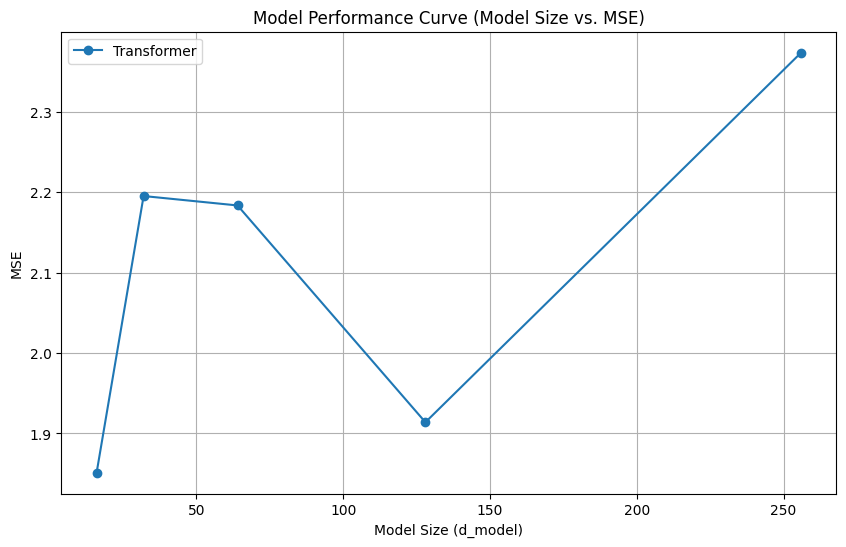

In [ ]:
import matplotlib.pyplot as plt

# Model sizes and corresponding MSE values from screenshots
model_sizes = [16, 32, 64, 128, 256]
mse_values = [1.8513, 2.1952, 2.1835, 1.9139, 2.3736]

# Plotting the performance curve
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, mse_values, label='Transformer', marker='o')
plt.xlabel('Model Size (d_model)')
plt.ylabel('MSE')
plt.title('Model Performance Curve (Model Size vs. MSE)')
plt.legend()
plt.grid(True)
plt.show()


R^2: 0.9981
Mean Squared Error: 1.5967
Mean Absolute Error: 0.8381


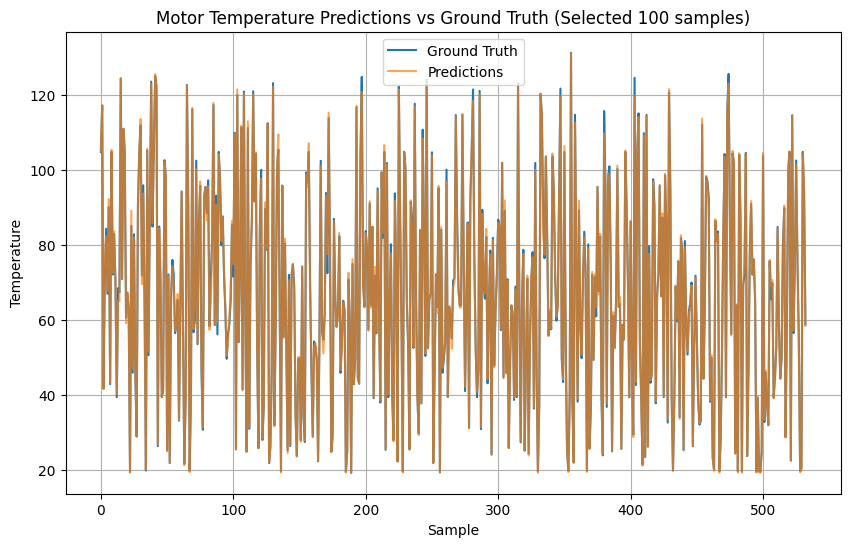

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2: {r2:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
# Select every 500th sample to get a cleaner plot with 100 samples
sample_indices = range(0, len(y_test), 500)


# Plotting the predictions against the ground truth for 100 selected samples
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor[sample_indices].numpy(), label='Ground Truth')
plt.plot(y_pred[sample_indices], label='Predictions', alpha=0.7)
plt.title('Motor Temperature Predictions vs Ground Truth (Selected 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()